<a href="https://colab.research.google.com/github/NathanW9/TrashDetection/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Classification:


---

<br>

This Project Focusses on the multi classification of household trash items. It aims to create a CNN to predict what type of trash something is and classify the image into the respective category.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the data from Kaggle:


---
<br>


We recieved the data set from kaggle. The images are already in named sub folders for each class.

In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("joebeachcapital/realwaste")

# Access dataset files
print("Path to dataset files:", path)

100%|██████████| 657M/657M [00:08<00:00, 83.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/joebeachcapital/realwaste/versions/1


In [ ]:
import os

# Set the dataset path to the cached location
dataset_path = r"/root/.cache/kagglehub/datasets/joebeachcapital/realwaste/versions/1"

# Check the files in the directory
print("Files in dataset:", os.listdir(dataset_path))

Files in dataset: ['realwaste-main']


In [ ]:
# Update the path to include the subdirectory
dataset_path = os.path.join(dataset_path, 'realwaste-main')

# Check the files in this subdirectory
print("Files in dataset:", os.listdir(dataset_path))

Files in dataset: ['RealWaste', 'README.md']


In [ ]:
# Update the path to include the RealWaste subdirectory
dataset_path = os.path.join(dataset_path, 'RealWaste')

# Check the files in this subdirectory
print("Files in dataset:", os.listdir(dataset_path))
print(dataset_path)

Files in dataset: ['Food Organics', 'Cardboard', 'Plastic', 'Vegetation', 'Glass', 'Textile Trash', 'Paper', 'Metal', 'Miscellaneous Trash']
/root/.cache/kagglehub/datasets/joebeachcapital/realwaste/versions/1/realwaste-main/RealWaste


# Importing Data and Data Augmentation


---


<br>

We Process the images using ImageDataGenerator from tensorflow and add data augmentation to the training set to help with overfitting. We have a data split of 80-20 for the training set and the cross validation set. The training set will have 3803 images and the cross validation set will have 949 images.

In [ ]:
import os
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define the path to the dataset
dataset_path = Path(dataset_path)

# Set up an ImageDataGenerator for loading and preprocessing the images
# data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adjust rescale as needed ------old data-gen
#new data_gen for data augmentation:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)



# Create training and validation generators
train_generator = data_gen.flow_from_directory(
    directory=dataset_path,
    target_size=(150, 150),
    batch_size=24,
    class_mode='categorical',
    subset='training'
)

#new data gen for validation because we dont want augmentation with cv set
validation_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

validation_generator = validation_data_gen.flow_from_directory(
    directory=dataset_path,
    target_size=(150, 150),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
)


num_classes = 9
class_weights = {i: 1.0 for i in range(num_classes)}
class_weights[7] = 1.25
class_weights[8] = 1.25

Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


## This is a sample of what the Data Augmentation has done to the images:

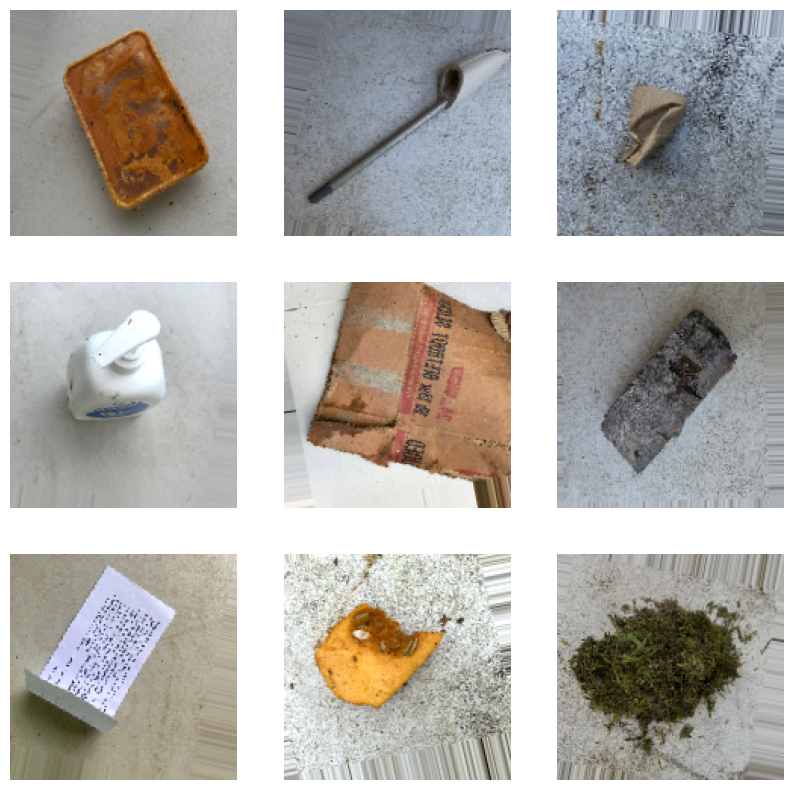

In [ ]:
import matplotlib.pyplot as plt

augmented_images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


# Model:


---
<br>

The model has a total of 18 layers. If you don't count activiation, batch normalization, and dropout layers, the model has 9 layers:

<br>

---
<br>


1. Conv2D Layer 1: Conv2D(32, (3, 3))
2. MaxPooling2D Layer 1: MaxPooling2D(pool_size=(2, 2))
3. Conv2D Layer 2: Conv2D(64, (3, 3))
4. MaxPooling2D Layer 2: MaxPooling2D(pool_size=(2, 2))
5. Conv2D Layer 3: Conv2D(128, (3, 3))
6. MaxPooling2D Layer 3: MaxPooling2D(pool_size=(2, 2))
7. Flatten Layer: Flatten()
8. Dense Layer 1: Dense(128)
9. Output Layer: Dense(9, activation='softmax')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Initialize the model
model = Sequential()

# Add a convolutional layer with reduced L2 regularization and batch normalization
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer with batch normalization and regularization
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with batch normalization and regularization
model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with reduced L2 regularization and dropout
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increased dropout for regularization

# Add the output layer (9 classes)
model.add(Dense(9, activation='softmax', kernel_regularizer=l2(0.001)))

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model and store the history
# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Print training and validation accuracy for each epoch
print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 61s 299ms/step - accuracy: 0.3142 - loss: 2.6260 - weighted_accuracy: 0.3164 - val_accuracy: 0.0885 - val_loss: 3.2545 - val_weighted_accuracy: 0.0885 - learning_rate: 1.0000e-04
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.4735 - loss: 2.0415 - weighted_accuracy: 0.4767 - val_accuracy: 0.1212 - val_loss: 3.1996 - val_weighted_accuracy: 0.1212 - learning_rate: 1.0000e-04
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 45s 267ms/step - accuracy: 0.5209 - loss: 1.8808 - weighted_accuracy: 0.5248 - val_accuracy: 0.3530 - val_loss: 2.2382 - val_weighted_accuracy: 0.3530 - learning_rate: 1.0000e-04
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 80s 258ms/step - accuracy: 0.5430 - loss: 1.7915 - weighted_accuracy: 0.5442 - val_accuracy: 0.4784 - val_loss: 1.9461 - val_weighted_accuracy: 0.4784 - learning_rate: 1.0000e-04
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.5695 - loss: 1.7048 - weighted_accuracy: 0.5712 - val_accuracy: 0.

# This Saves the Model to the shared google drive

---


In [ ]:
from google.colab import drive
from tensorflow.keras.models import save_model

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your shared folder
shared_folder_path = '/content/drive/My Drive/WasteClassification'
model_save_path = f'{shared_folder_path}/my_model.keras'

# Save the model
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to: /content/drive/My Drive/WasteClassification/my_model.keras


# Training and cross validation accuracy:


---



In [ ]:
# After training, print only the last accuracy values
train_accuracy_last = history.history['accuracy'][-1]
val_accuracy_last = history.history['val_accuracy'][-1]

print(f"Final training accuracy: {train_accuracy_last}")
print(f"Final validation accuracy: {val_accuracy_last}")


Final training accuracy: 0.7291612029075623
Final validation accuracy: 0.5268703699111938


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for validation data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


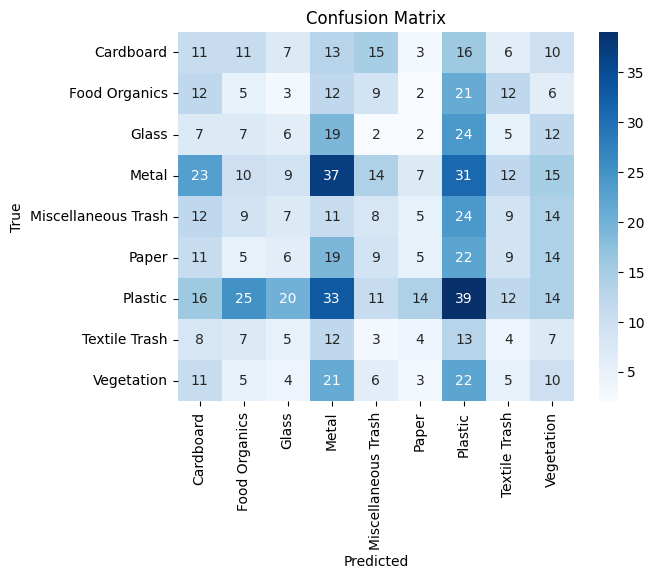

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# This is the Test Data being imported from Google shared drive:


---

<br>

We decided to use a different set of pictures as the test set to really challenge our model. The pictures are much different than the ones used int the training and validation set.



In [ ]:
import os

Set the path to the shared folder in Google Drive
shared_folder_path = '/content/drive/My Drive/WasteClassification'

#Verify the path
print("Files in shared folder:", os.listdir(shared_folder_path))


Files in shared folder: ['ML Project.gdoc', 'Log.gdoc', 'Process.gdoc', 'RealWasteTestSet', 'RealWasteTestSet001.zip', 'Waste Classification.gslides', 'my_model.h5', 'my_model.keras']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Set up ImageDataGenerator for test data
test_data_gen = ImageDataGenerator(rescale=1./255)

#Create the test generator with the correct path and settings
test_generator = test_data_gen.flow_from_directory(
    directory=os.path.join(shared_folder_path, 'RealWasteTestSet'),
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Print class indices for verification
print("Class indices detected:", test_generator.class_indices)


Found 15 images belonging to 9 classes.
Class indices detected: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscelaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


# This imports the saved model from the google drive and inlcudes a model summary/sanity check to make sure the model is correct:


---



In [ ]:
from tensorflow.keras.models import load_model

Load the saved model from Google Drive
model_path = '/content/drive/My Drive/WasteClassification/my_model.keras'  # Path to your saved model
model = load_model(model_path)

# Check the model summary for the output layer
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,661,140 (36.85 MB)

 Trainable params: 4,830,217 (18.43 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 4,830,219 (18.43 MB)

In [ ]:
#Evaluate the model on the test data
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3817 - loss: 4.5991 - weighted_accuracy: 0.3817
Test Loss: 4.453969955444336
Test Accuracy: 0.2666666805744171


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Make predictions and analyze results
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Print shapes for verification
print("Shape of y_true:", y_true.shape)
print("Shape of y_pred:", y_pred.shape)

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Shape of y_true: (15,)
Shape of y_pred: (15,)
                    precision    recall  f1-score   support

         Cardboard       0.18      1.00      0.31         2
     Food Organics       0.00      0.00      0.00         1
             Glass       0.00      0.00      0.00         2
             Metal       0.00      0.00      0.00         2
Miscelaneous Trash       0.00      0.00      0.00         2
             Paper       0.00      0.00      0.00         2
           Plastic       0.00      0.00      0.00         1
     Textile Trash       0.00      0.00      0.00         1
        Vegetation       0.50      1.00      0.67         2

          accuracy                           0.27        15
         macro avg       0.08      0.22      0.11        15
      weighted avg       0.09      0.27      0.13        15



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


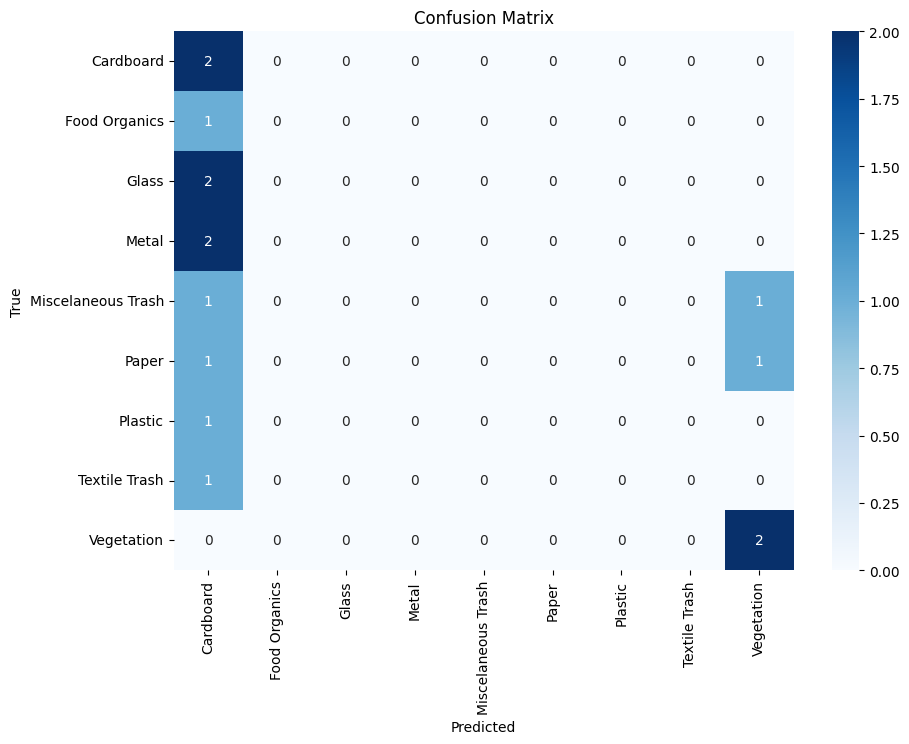

In [ ]:
#Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Conlcusion:


---

<br>


### We ended up with a test accuracy of 26% which is above random guessing. We would have liked to get higher because in real world application 26% chance you correctly identify your trash isn't good enough to use on a daily basis, but with more time we would have liked to increase the data size and tweak our model. Our next steps after increasing test set accruacy would be to build a web app or a space to quickly import your own images and test it using our model.

### Other Model Below
----------------------
<br>
This code was used to analyze the error of our model based on the size of the data set. We collected the average error in the model's predictions for every 10 percent interval of the training set size.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 950ms/step - accuracy: 0.1288 - loss: 5.1886 - val_accuracy: 0.1602 - val_loss: 2.5335
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 941ms/step - accuracy: 0.1965 - loss: 2.1636 - val_accuracy: 0.1876 - val_loss: 2.1829
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 614ms/step - accuracy: 0.2534 - loss: 2.1457 - val_accuracy: 0.2255 - val_loss: 2.0469
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 646ms/step - accuracy: 0.3255 - loss: 2.0127 - val_accuracy: 0.2687 - val_loss: 1.9909
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - accuracy: 0.2709 - loss: 2.0066 - val_accuracy: 0.2529 - val_loss: 2.1094
1 Done!
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 504ms/step - accuracy: 0.1188 - loss: 15.7064 - val_accuracy: 0.1096 - val_loss: 2.2744
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.1364 - loss: 2.1962 - val_accuracy: 0.2845 - val_loss: 2.0402
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.3020 - loss: 2.0678 - val_accuracy: 0.2308 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.3602 - loss: 1.7951 - val_accuracy: 0.3066 - val_loss: 2.0160
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 398ms/step - accuracy: 0.3606 - loss: 1.7510 - val_accuracy: 0.2845 - val_loss: 2.0875
3 Done!
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.1809 - loss: 7.4334 - val_accuracy: 0.2961 - val_loss: 2.0661
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - accuracy: 0.2909 - loss: 1.9397 - val_accuracy: 0.2740 - val_loss: 2.1603
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.3531 - loss: 1.7662 - val_accuracy: 0.3182 - val_loss: 2.0384
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.4070 - loss: 1.6447 - val_accuracy: 0.2887 - val_loss: 2.1614
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - accuracy: 0.4400 - loss: 1.5408 - val_accuracy: 0.3456 - val_loss: 2.0218
4 Done!
Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.1654 - loss: 11.9843 - val_accurac

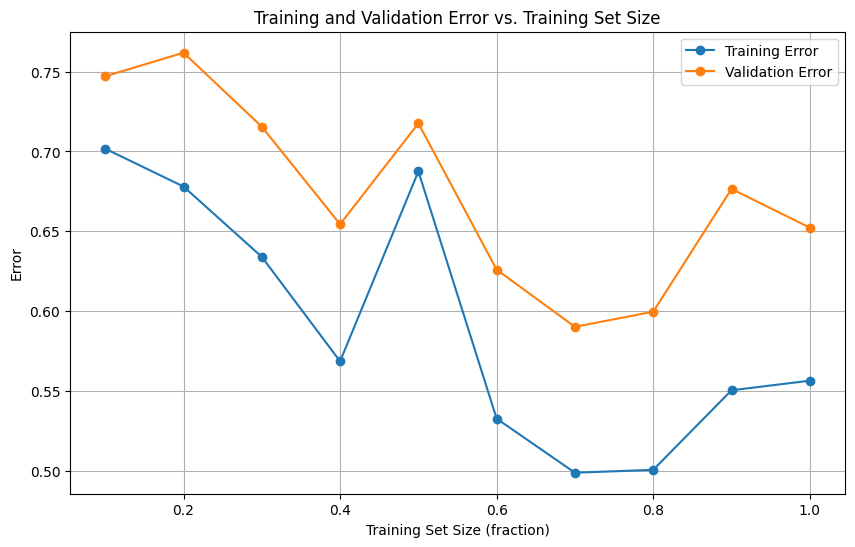

In [ ]:

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

train_sizes = np.linspace(0.1, 1.0, 10)  # 10 steps from 10% to 100% of the training data
training_errors = []
validation_errors = []
epoch = 1
for size in train_sizes:
    # Calculate steps per epoch based on the subset size
    #steps_per_epoch = max(1, int(len(train_generator) * size))
    steps_per_epoch = max(1, int(len(train_generator.filenames) * size // train_generator.batch_size))


    # Create and compile a new model for each iteration
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(9, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the subset
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )
    print(epoch, "Done!")
    epoch += 1

    # Record errors (1 - accuracy)
    training_errors.append(1 - history.history['accuracy'][-1])
    validation_errors.append(1 - history.history['val_accuracy'][-1])

    # Clear model from memory
    K.clear_session()

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, training_errors, label='Training Error', marker='o')
plt.plot(train_sizes, validation_errors, label='Validation Error', marker='o')
plt.title('Training and Validation Error vs. Training Set Size')
plt.xlabel('Training Set Size (fraction)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for the test set (no augmentation, just rescaling)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test set
test_generator = test_data_gen.flow_from_directory(
    directory=testSet_path,         # Path to the test set
    target_size=(150, 150),         # Same target size as used in training
    batch_size=32,
    class_mode='categorical',       # As it was in training
    shuffle=False                   # No need to shuffle test data
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print the results dynamically
print(f"Results: {results}")

# Dynamically unpack the results based on the length
if len(results) == 2:
    test_loss, test_acc = results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")
elif len(results) == 3:
    test_loss, test_acc, test_weighted_acc = results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Weighted Accuracy: {test_weighted_acc}")
elif len(results) == 4:
    test_loss, test_acc, test_weighted_acc, extra_metric = results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Weighted Accuracy: {test_weighted_acc}")
    print(f"Extra Metric: {extra_metric}")
else:
    print("Unexpected number of values returned:", len(results))



Found 15 images belonging to 9 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - accuracy: 0.2000 - loss: 3.7570 - weighted_accuracy: 0.2000
Results: [3.7570290565490723, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224]
Test Loss: 3.7570290565490723
Test Accuracy: 0.20000000298023224
Test Weighted Accuracy: 0.20000000298023224
Extra Metric: 0.20000000298023224
